In [1]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
warnings.filterwarnings("ignore")
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from tqdm import tqdm

## Import data

In [4]:
credentials = service_account.Credentials.from_service_account_file('bigquery-production.json')
project_id = 'production-247608'
client = bigquery.Client(credentials= credentials,project=project_id)

query_job = client.query("""
    SELECT user_pseudo_id, session_id, timestamp_local, event_name, clean_path
    FROM `production-247608.dataform.ga4_raw_flat_nl` 
    WHERE date >= '2024-05-10' """)
raw_data = query_job.result().to_dataframe()

## Preprocessing

In [5]:
events = ['session_start', 'showrooms_info_view', 'showroom_appointment_step', 'category_banner_view', 'inspiratie_view',
          'advies_view', 'mijnsanitair_view', 'view_item_list', 'view_item', 'add_to_cart', 
          'remove_from_cart', 'begin_checkout', 'view_cart', 'add_to_wishlist', 'view_search_results',
          'product_compare']

In [6]:
data_cleaned = raw_data[raw_data['event_name'].isin(events)]

In [7]:
data_cleaned = data_cleaned.sort_values(['session_id','timestamp_local']).reset_index(drop=True)
# drop row if the previous row has the same session_id, event_name and clean_path 
mask = (data_cleaned['session_id'] == data_cleaned['session_id'].shift(1)) & \
        (data_cleaned['event_name'] == data_cleaned['event_name'].shift(1)) & \
        (data_cleaned['clean_path'] == data_cleaned['clean_path'].shift(1))
data_cleaned = data_cleaned[~mask]

### Minimum session time

In [8]:
session_start_time = data_cleaned.groupby('session_id')['timestamp_local'].min()
session_end_time = data_cleaned.groupby('session_id')['timestamp_local'].max()
session_length = pd.merge(session_start_time, session_end_time, on='session_id', how='left', suffixes=(' start', ' end'))
session_length['session_length'] = session_length['timestamp_local end']-session_length['timestamp_local start']
minimum_30_seconds = session_length[session_length['session_length'] > '0 days 00:00:30']
data = data_cleaned[data_cleaned['session_id'].isin(minimum_30_seconds.index)]
data = data.sort_values(by=['session_id','timestamp_local']).reset_index(drop=True)

### Add variables

In [9]:
data_sorted = data.sort_values(['session_id','timestamp_local']).reset_index(drop=True)
# create a column with the time between the consecutive events if the session ids are the same otherwise the time is pd.NaT
data_sorted['time_between_events'] = data_sorted['timestamp_local'].diff().where(data_sorted['session_id'].eq(data_sorted['session_id'].shift())).fillna(pd.Timedelta(seconds=0))

In [10]:
# create a column with the time between the current event and the start of the session
data_sorted = data_sorted.sort_values(['session_id','timestamp_local']).reset_index(drop=True)
data_sorted['time_since_session_start'] = data_sorted['timestamp_local'] - data_sorted.groupby('session_id')['timestamp_local'].transform('first')

In [11]:
data_sorted = data_sorted.sort_values(['session_id','timestamp_local']).reset_index(drop=True)
data_sorted['number of events'] =  data_sorted.groupby('session_id').cumcount() + 1
data_sorted['total number of events'] = data_sorted.groupby('session_id')['number of events'].transform('max')

In [12]:
data_min_events = data_sorted[(data_sorted['total number of events'] >= 5) & (data_sorted['total number of events'] <= 20)]

## ML preprocessing

### Tokenize and pad sequences

In [13]:
data_ml = data_min_events.sort_values(['session_id','timestamp_local']).reset_index(drop=True)

if 'event_list' not in data_ml:
    data_ml['event_list'] = [[] for _ in range(len(data_ml))]
if 'tsst_list' not in data_ml:
    data_ml['tsst_list'] = [[] for _ in range(len(data_ml))]
if 'tbe_list' not in data_ml:
    data_ml['tbe_list'] = [[] for _ in range(len(data_ml))]
if 'prefix_id' not in data_ml:
    data_ml['prefix_id'] = [None for _ in range(len(data_ml))]

users = data_ml['session_id'].unique()
for user in tqdm(users):
    user_data = data_ml[data_ml['session_id'] == user]
    prefix_extension = 0
    event_list = []
    tsst_list = []
    tbe_list = []
    for idx in user_data.index:
        data_ml.at[idx, 'prefix_id'] = f'{user}_{prefix_extension}'
        prefix_extension += 1

        event_list.append(data_ml.at[idx, 'event_name'])
        data_ml.at[idx, 'event_list'] = event_list.copy()
        
        tsst_list.append(data_ml.at[idx, 'time_since_session_start'])
        data_ml.at[idx, 'tsst_list'] = tsst_list.copy()

        tbe_list.append(data_ml.at[idx, 'time_between_events'])
        data_ml.at[idx, 'tbe_list'] = tbe_list.copy()

100%|██████████| 178261/178261 [11:22<00:00, 261.30it/s]


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
custom_filters = '!\"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n'
tokenizer = Tokenizer(filters=custom_filters)
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Tokenize the event_list to numbers = integer tokenization
events_for_tokenization = []
for event_list in data_ml['event_list']:
    events_for_tokenization += event_list
    
tokenizer.fit_on_texts(events_for_tokenization)

data_ml['tokenized_event_list'] = data_ml['event_list'].apply(lambda x: [tokenizer.texts_to_sequences([y])[0][0] for y in x])

# Pre-Pad the tokenized text with 0's
data_ml['tokenized_event_list'] = list(pad_sequences(data_ml['tokenized_event_list'], value=-1))
data_ml['tbe_list'] = data_ml['tbe_list'].apply(lambda x: [y.total_seconds() for y in x])
data_ml['tsst_list'] = data_ml['tsst_list'].apply(lambda x: [y.total_seconds() for y in x])

data_ml['tbe_list_padded'] = list(pad_sequences(data_ml['tbe_list'], value=-1))
data_ml['tsst_list_padded'] = list(pad_sequences(data_ml['tsst_list'], value=-1))

### Create target variable

In [21]:
decision_points = data_ml[((data_ml['event_name'] == 'showrooms_info_view') | (data_ml['event_name'] == 'showroom_appointment_step'))].index
data_ml['decision_point'] = 0
data_ml.loc[decision_points, 'decision_point'] = 1
showroom_users = data_ml[data_ml['decision_point'] == 1]['session_id'].unique()
data_ml['target'] = data_ml['session_id'].apply(lambda x: 1 if x in showroom_users else 0)

### Truncate the sessions at its first decision point

In [22]:
# based on the decision points, remove all prefixes from a session after the first decision point in that session
def truncate_after_decision(session_data):
    # Check if there's a decision point in this session
    if session_data['decision_point'].sum() > 0:
        # Get the index of the first decision point
        decision_index = session_data[session_data['decision_point']==1].index.min()
        # Return data up to and including the decision point
        return session_data.loc[:decision_index-1]
    else:
        # Return the session data as is if there's no decision point
        return session_data

In [23]:
# Group by session_id and apply the truncation
truncated_sessions = data_ml.groupby('session_id').apply(truncate_after_decision).reset_index(drop=True)

In [24]:
truncated_sessions['target'].value_counts()

target
0    1351134
1      64668
Name: count, dtype: int64

### train test split

In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X = truncated_sessions[['tokenized_event_list', 'tbe_list_padded', 'tsst_list_padded']]
y = truncated_sessions['target']

X_flattened = np.array([np.concatenate([row[col] for col in X.columns]) for _, row in X.iterrows()])

X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=123)

#smote = SMOTE(random_state=123)
#X_train_flat_oversampled, y_train = smote.fit_resample(X_train_flat, y_train)
target_0 = truncated_sessions['target'].value_counts()[0]
ros = RandomOverSampler(sampling_strategy={0: target_0, 1: round(target_0*0.4)})
X_train_flat_oversampled, y_train = ros.fit_resample(X_train_flat, y_train)
#rus = RandomUnderSampler(random_state=42)
#X_train_flat_oversampled, y_train = rus.fit_resample(X_train_flat, y_train)

In [28]:
y_train.value_counts()

target
0    1351134
1     540454
Name: count, dtype: int64

In [31]:
X.shape

(1415802, 3)

### ML modelling

LSTM Classifier

In [34]:
import tensorflow as tf

# Reshape the data back to its original structure for the LSTM
n_features = 3  
n_timesteps = 20
X_train_oversampled = X_train_flat_oversampled.reshape(-1, n_timesteps, n_features)
X_test = X_test_flat.reshape(-1, n_timesteps, n_features)
print(X_train_oversampled.shape)
# Define the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True, input_shape=(20,3)),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.AUC()])

# Train the model
model.fit(X_train_oversampled, y_train, epochs=15, batch_size=512, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

(1891588, 20, 3)
Epoch 1/15
2956/2956 [==============================] - 111s 36ms/step - loss: 0.3306 - auc_2: 0.6467 - val_loss: 2.0817 - val_auc_2: 0.0000e+00
Epoch 2/15
2956/2956 [==============================] - 109s 37ms/step - loss: 0.3236 - auc_2: 0.6657 - val_loss: 2.1264 - val_auc_2: 0.0000e+00
Epoch 3/15
2956/2956 [==============================] - 112s 38ms/step - loss: 0.3218 - auc_2: 0.6724 - val_loss: 2.0908 - val_auc_2: 0.0000e+00
Epoch 4/15
2956/2956 [==============================] - 114s 39ms/step - loss: 0.3211 - auc_2: 0.6758 - val_loss: 2.0526 - val_auc_2: 0.0000e+00
Epoch 5/15
2956/2956 [==============================] - 117s 39ms/step - loss: 0.3208 - auc_2: 0.6779 - val_loss: 2.0456 - val_auc_2: 0.0000e+00
Epoch 6/15
2956/2956 [==============================] - 120s 41ms/step - loss: 0.3205 - auc_2: 0.6793 - val_loss: 2.0748 - val_auc_2: 0.0000e+00
Epoch 7/15
2956/2956 [==============================] - 122s 41ms/step - loss: 0.3204 - auc_2: 0.6801 - val_loss:

In [35]:
model.save('LSTM-068AUC.keras')

In [36]:
y_prob = model.predict(X_test)

In [37]:
y_pred = (y_prob > 0.5).astype(int)

In [38]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.6801130789790986


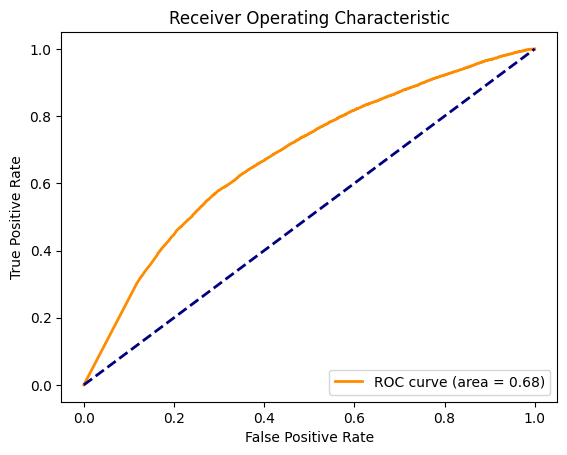

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Import model

In [41]:
model_loaded = tf.keras.models.load_model('../models/LSTM-20e-128bs')

In [42]:
y_prob = model_loaded.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)
print(sum(y_pred))
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc}")

[74005]
AUC-ROC: 0.48829130207069094
